In [1]:
import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb

from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split

import util

In [2]:
RANDOM_SEED = 42

In [3]:
ORIGINS_PATH = "/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"
df_origins = util.load_origins_df(ORIGINS_PATH)

In [4]:
MINIMAP2_OVLPS = "/storage2/tbrekalo/HG002-simulated/chr19-sample-minimap2-ovlps.paf"
TB_RAM_OVLPS_AI = "/storage2/tbrekalo/HG002-simulated/chr19-sample-tb-ram-ovlps-ai.tsv"
RAM_OVLPS = "/storage2/tbrekalo/HG002-simulated/chr19-sample-ram-ovlps.paf"

In [5]:
df_ovlps_minimap2 = util.create_annotated_overlaps_from_ava(
    util.load_paf_df(MINIMAP2_OVLPS),
    df_origins,
).filter(pl.col("query-name") != pl.col("target-name"))

In [6]:
def create_df_ai_ram(df_input: pl.DataFrame, df_origins: pl.DataFrame) -> pl.DataFrame:
    return (
        util.calc_ava_origin_overlap(
            util.expand_ava_with_origin_info(
                df_ava=pl.read_csv(
                    df_input,
                    has_header=False,
                    new_columns=util.RAM_OVERLAP_AI_COLUMNS,
                    separator="\t",
                ),
                df_origins=df_origins,
            )
        )
        .select(
            *util.RAM_OVERLAP_AI_COLUMNS,
            ((pl.col("ratio") > 0.825) & pl.col("matching-strands"))
            .cast(pl.Int64)
            .alias("label"),
        )
        .with_columns(
            pl.when(pl.col("strand") == "+")
            .then(pl.lit(1))
            .otherwise(pl.lit(0))
            .alias("strand"),
            pl.min_horizontal(
                pl.col("query-matches"),
                pl.col("target-matches"),
            ).alias("n-residue-matches"),
        )
    )


df_ovlps_tb_ram = create_df_ai_ram(TB_RAM_OVLPS_AI, df_origins)

In [7]:
df_ovlps_ram = util.create_annotated_overlaps_from_ava(
    util.load_paf_df(RAM_OVLPS),
    df_origins,
)

In [8]:
print(df_ovlps_minimap2.select(pl.col("label").value_counts()))
print(df_ovlps_tb_ram.select(pl.col("label").value_counts()))
print(df_ovlps_ram.select(pl.col("label").value_counts()))

shape: (2, 1)
┌────────────┐
│ label      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {0,295902} │
│ {1,557}    │
└────────────┘
shape: (2, 1)
┌───────────┐
│ label     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,14098} │
│ {1,154}   │
└───────────┘
shape: (2, 1)
┌────────────┐
│ label      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {0,125919} │
│ {1,203}    │
└────────────┘


n-unique-pairs,overlap-length-mean,overlap-length-std,overlap-length-q25,overlap-length-median,overlap-length-q75,label
u32,f64,f64,f64,f64,f64,str
108,4175.231598,6575.593054,321.0,771.0,3064.0,"""minimap2"""
133,6242.298701,5997.838148,1189.0,3814.5,11291.0,"""tb-ram"""
114,11411.669951,7311.35418,3361.0,15397.0,17376.0,"""ram"""


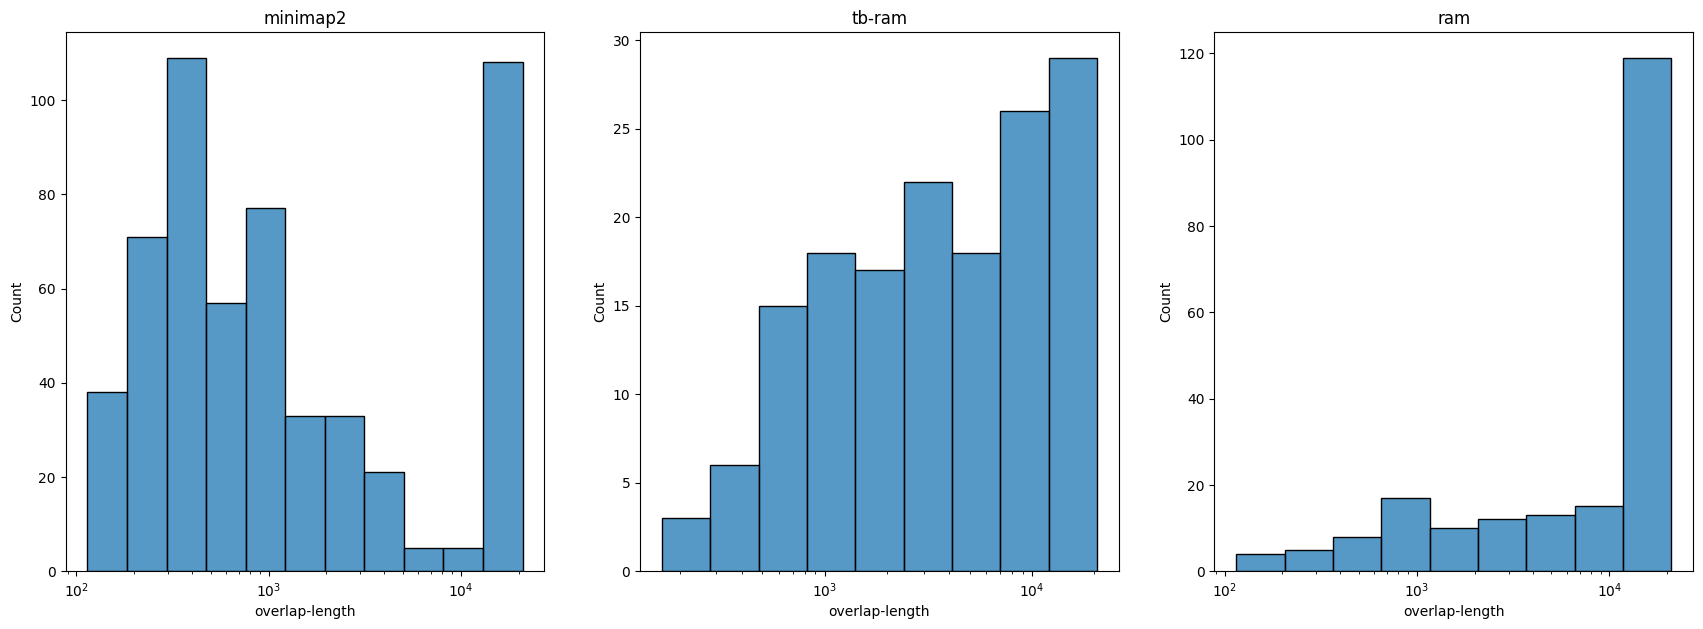

In [9]:
dfs = {
    "minimap2": df_ovlps_minimap2,
    "tb-ram": df_ovlps_tb_ram,
    "ram": df_ovlps_ram,
}

fig, ax = plt.subplots(1, len(dfs), figsize=(21, 7))


def overlap_metrics(df_in: pl.DataFrame, label: str, ax_idx: int) -> pl.DataFrame:
    df_work = df_in.filter(label=1).with_columns(
        pl.max_horizontal(
            (pl.col("query-end") - pl.col("query-start")),
            (pl.col("target-end") - pl.col("target-start")),
        ).alias("overlap-length")
    )

    ax[ax_idx].set_title(label)
    sns.histplot(
        df_work.to_pandas(),
        x="overlap-length",
        ax=ax[ax_idx],
        log_scale=True,
    )

    return df_work.select(
        pl.struct(["query-name", "target-name"]).n_unique().alias("n-unique-pairs"),
        pl.col("overlap-length").mean().alias("overlap-length-mean"),
        pl.col("overlap-length").std().alias("overlap-length-std"),
        pl.col("overlap-length").quantile(0.25).alias("overlap-length-q25"),
        pl.col("overlap-length").median().alias("overlap-length-median"),
        pl.col("overlap-length").quantile(0.75).alias("overlap-length-q75"),
        pl.lit(label).alias("label"),
    )


pl.concat(
    [overlap_metrics(df, name, idx) for idx, (name, df) in enumerate(dfs.items())]
)

In [10]:
df_ovlps_minimap2.filter(label=1).group_by(
    "query-name",
    "target-name",
    "strand",
).agg(
    pl.len(),
).filter(
    pl.col("len") > 1,
).select(
    "query-name",
    "target-name",
).join(
    df_ovlps_tb_ram,
    on=[
        "query-name",
        "target-name",
    ],
).sort("strand", "query-name", "target-name", "query-start", "query-end", "target-start", "target-end",)

query-name,target-name,query-length,query-start,query-end,query-matches,strand,target-length,target-start,target-end,target-matches,score,diff-mean,q75,q90,q95,q98,label,n-residue-matches
str,str,i64,i64,i64,i64,i32,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
"""S1_12731_chr19…","""S1_42592_chr19…",17391,1,3490,3288,0,19548,12245,15733,3288,2054.781788,3.439604,4,5,5,13,1,3288
"""S1_1355_chr19""","""S1_70194_chr19…",20786,316,4139,3425,0,19350,15522,19347,3426,2122.109906,3.630124,4,5,5,15,1,3425
"""S1_1355_chr19""","""S1_70194_chr19…",20786,3423,3903,255,0,19350,12326,12804,255,137.953667,10.813953,5,29,48,91,1,255
"""S1_1355_chr19""","""S1_70194_chr19…",20786,6860,7338,255,0,19350,15758,16238,255,137.953667,10.767442,5,29,48,91,1,255
"""S1_13607_chr19…","""S1_68117_chr19…",18151,5065,5563,266,0,20586,18514,19014,266,143.773269,9.113208,5,25,36,63,0,266
"""S1_16155_chr19…","""S1_356_chr19""",20036,4,4941,4659,0,20987,15499,20437,4660,2920.931198,3.505698,4,5,5,13,1,4659
"""S1_16536_chr19…","""S1_63163_chr19…",20364,0,1186,1136,0,18424,17165,18354,1136,715.988201,3.516517,4,5,5,17,1,1136
"""S1_16536_chr19…","""S1_63163_chr19…",20364,3395,4262,336,0,18424,10345,11217,336,142.717266,14.440678,5,47,91,97,1,336
"""S1_16536_chr19…","""S1_63163_chr19…",20364,7182,8021,315,0,18424,14094,14926,315,130.569258,14.714286,5,47,91,111,1,315


In [11]:
FEATURE_COLS = [
    "diff-mean",
    "q75",
    "q90",
    "q95",
    "q98",
    "query-matches-normed",
    "target-matches-normed",
    "matches-normed",
    "matches-normed-diff",
    "label",
]
df_experiment = (
    (
        df_ovlps_tb_ram.with_columns(
            (pl.col("query-end") - pl.col("query-start")).alias("query-overlap-length"),
            (pl.col("target-end") - pl.col("target-start")).alias(
                "target-overlap-length"
            ),
        )
        .with_columns(
            pl.max_horizontal(
                pl.col("query-overlap-length"),
                pl.col("target-overlap-length"),
            ).alias("overlap-length"),
            (pl.col("query-overlap-length") - pl.col("target-overlap-length"))
            .abs()
            .alias("overlap-length-diff"),
        )
        .with_columns(
            (pl.col("query-matches") / pl.col("query-overlap-length")).alias(
                "query-matches-normed"
            ),
            (pl.col("target-matches") / pl.col("target-overlap-length")).alias(
                "target-matches-normed"
            ),
            (pl.col("n-residue-matches") / pl.col("overlap-length")).alias(
                "matches-normed"
            ),
        )
        .with_columns(
            (pl.col("query-matches-normed") - pl.col("target-matches-normed"))
            .abs()
            .alias("matches-normed-diff")
        )
    )
    .group_by("query-name", "target-name", "strand")
    .agg(
        *FEATURE_COLS,
        pl.len().alias("n-group-overlaps"),
    )
    .explode(FEATURE_COLS)
    .drop(
        "strand",
        "query-name",
        "target-name",
        "n-group-overlaps",
    )
)

<Axes: >

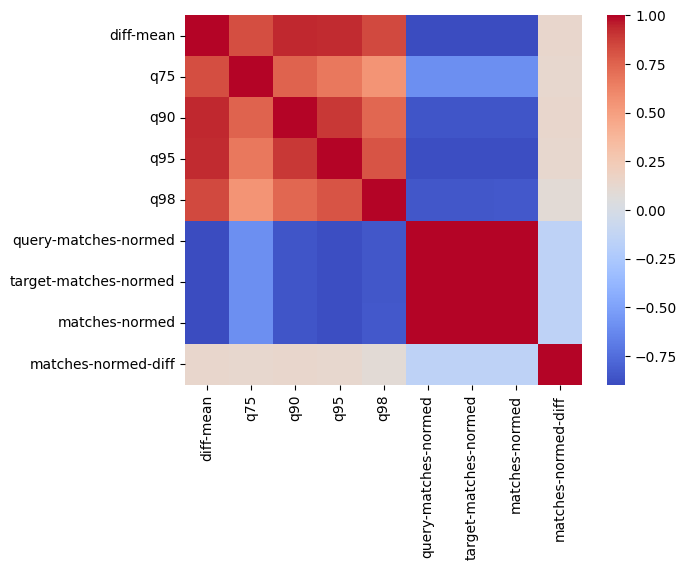

In [12]:
sns.heatmap(df_experiment.drop("label").to_pandas().corr(), cmap="coolwarm")

<Axes: xlabel='query-matches-normed', ylabel='target-matches-normed'>

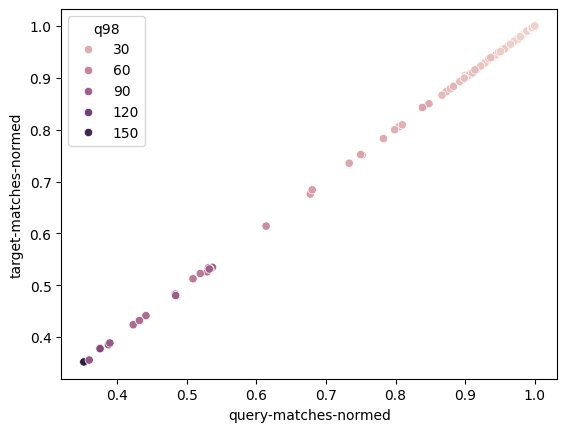

In [13]:
sns.scatterplot(
    df_experiment.filter(
        label=1
    ).filter(
        (pl.col("target-matches-normed") - pl.col("query-matches-normed")).abs() < 1
    ).to_pandas(), x="query-matches-normed", y="target-matches-normed", hue="q98")

In [14]:
palette = {
    0: "blue",
    1: "orange",
}

<Axes: xlabel='query-matches-normed', ylabel='target-matches-normed'>

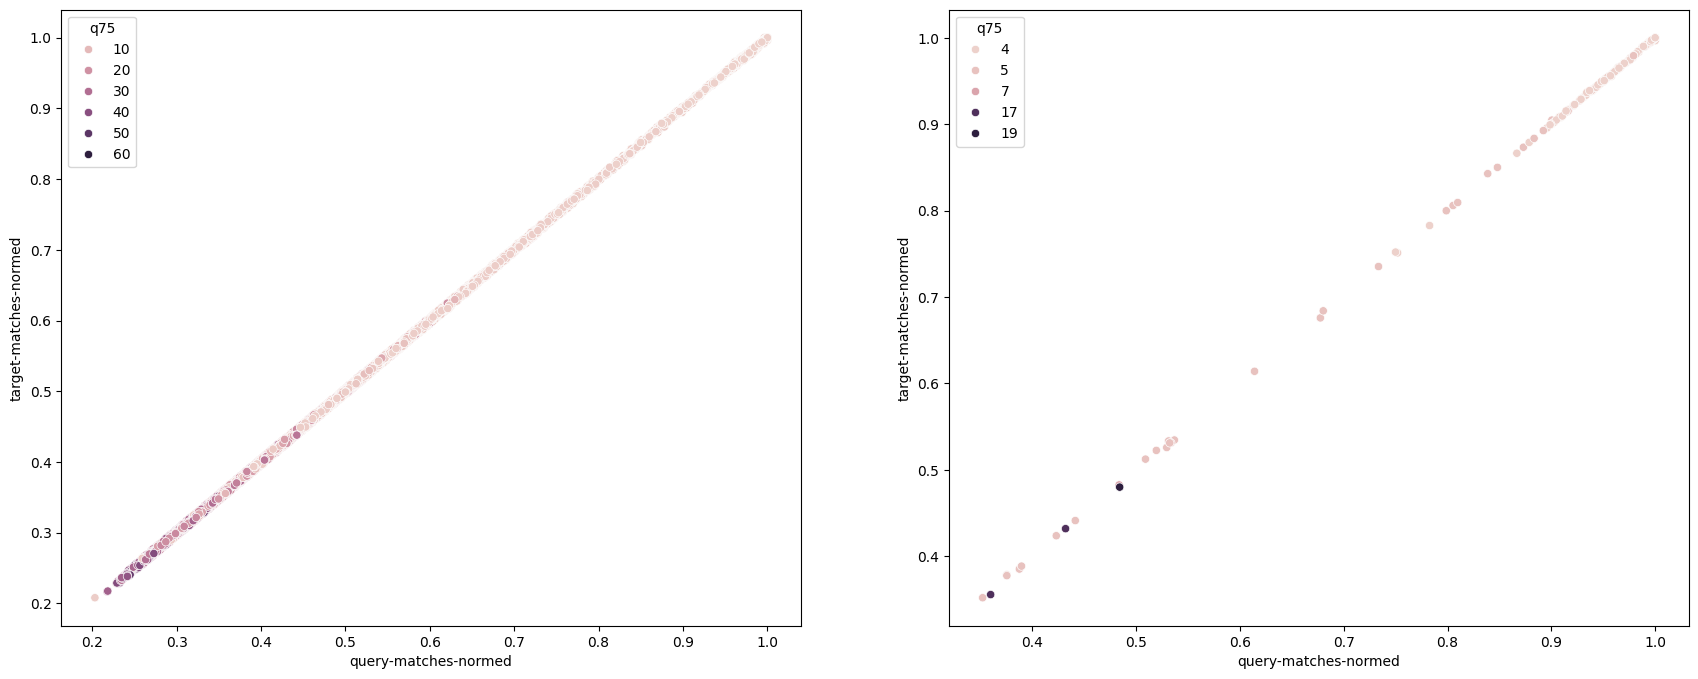

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(21, 8))
sns.scatterplot(df_experiment.filter(label=0).to_pandas(), x="query-matches-normed", y="target-matches-normed", hue="q75", ax=ax[0])
sns.scatterplot(df_experiment.filter(label=1).to_pandas(), x="query-matches-normed", y="target-matches-normed", hue="q75", ax=ax[1])

In [16]:
tree_expr = (
    pl.col("target-matches-normed") - pl.col("query-matches-normed")
).abs() < 0.2

rbf_exprs = [
    
]

MODEL_FEATURES = [
    feature
    for pair in (
        (
            (pl.col(feature_name) * tree_expr).alias(feature_name),
            (pl.col(feature_name) * (1 - tree_expr)).alias(f"{feature_name}-neg"),
        )
        for feature_name in FEATURE_COLS if feature_name != "label"
    )
    for feature in pair
]

df_model_features = df_experiment.select(
    *MODEL_FEATURES,
    "label",
)

In [17]:
df_train, df_test = train_test_split(
    df_model_features.to_pandas(),
    train_size=0.7,
    random_state=RANDOM_SEED,
)

class_weights={k: v for k, v in zip([0, 1], compute_class_weight(class_weight="balanced",  classes=np.unique(df_train["label"]), y=df_train["label"],))}

In [18]:
model = RidgeClassifier(class_weight=class_weights)
model.fit(df_train.drop("label", axis=1), df_train["label"])
y_model_pred = model.predict(df_test.drop("label", axis=1))
print(
    classification_report(
        y_true=df_test["label"],
        y_pred=y_model_pred,
    )
)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      4234
           1       0.06      0.86      0.12        42

    accuracy                           0.88      4276
   macro avg       0.53      0.87      0.53      4276
weighted avg       0.99      0.88      0.93      4276



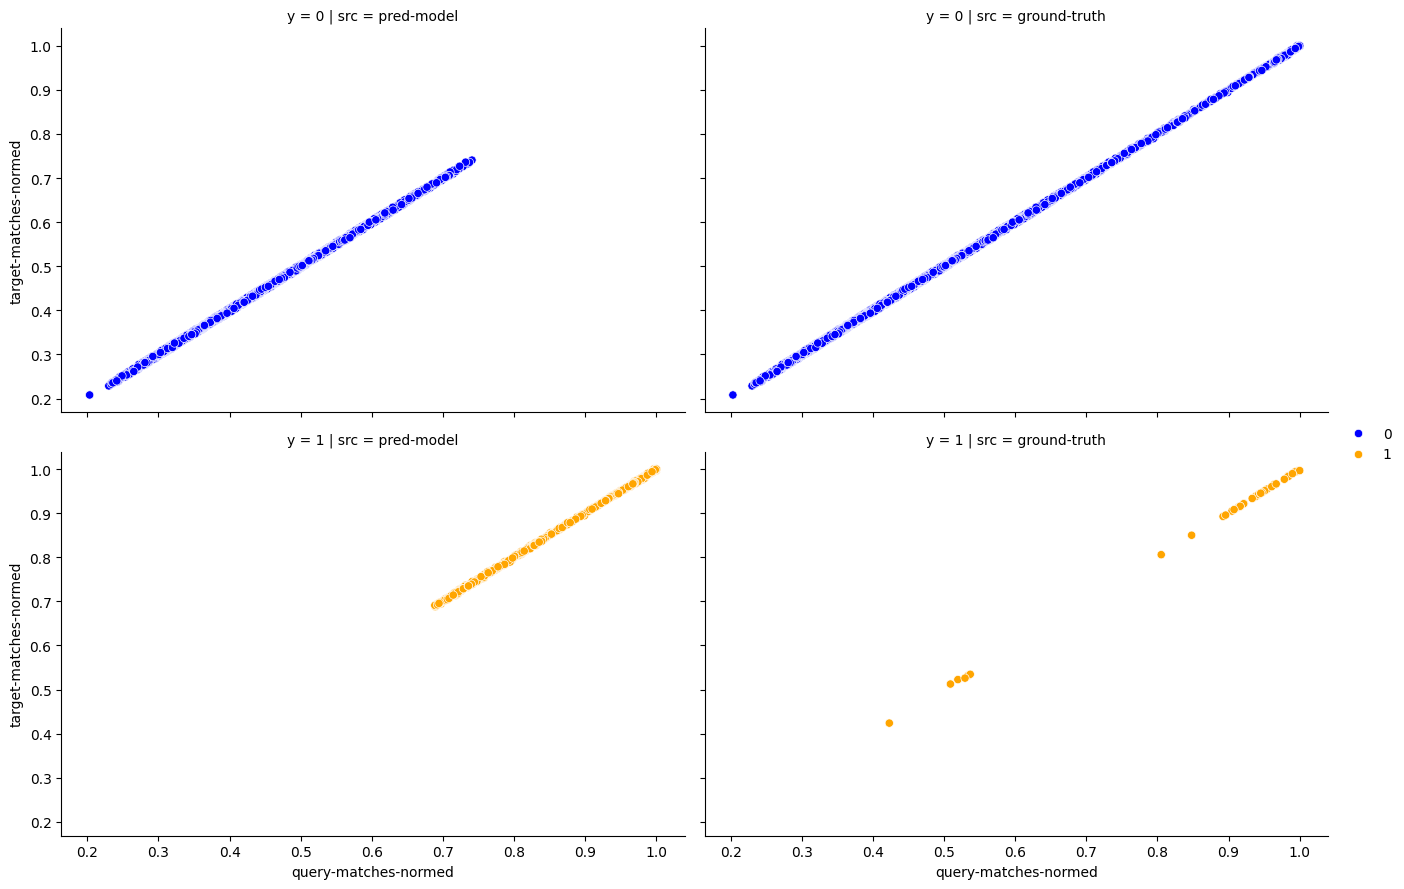

In [19]:
df_result = pd.concat(
    [
        df_test.assign(y=y_model_pred, src="pred-model"),
        df_test.assign(y=df_test["label"], src="ground-truth"),
    ],
)
g = sns.FacetGrid(df_result, col="src", row="y")
g.fig.set_size_inches(13.5, 9)
g.map_dataframe(
    sns.scatterplot,
    x="query-matches-normed",
    y="target-matches-normed",
    hue="y",
    palette={
        0: 'blue',
        1: 'orange',
    },
)
g.add_legend()

In [20]:
sorted(
    list(zip(model.feature_names_in_, model.coef_[0])),
    key=lambda kv: kv[1] ** 2,
    reverse=True,
)

[('matches-normed', 1.5201489249519644),
 ('query-matches-normed', 1.5041789566741968),
 ('target-matches-normed', 1.2504227850251244),
 ('diff-mean', 0.109300036254243),
 ('matches-normed-diff', 0.09449715088904041),
 ('q75', -0.029673513778084352),
 ('q90', -0.006477612183488728),
 ('q95', 0.005405438679438394),
 ('q98', -0.003864743488070831),
 ('diff-mean-neg', 0.0),
 ('q75-neg', 0.0),
 ('q90-neg', 0.0),
 ('q95-neg', 0.0),
 ('q98-neg', 0.0),
 ('query-matches-normed-neg', 0.0),
 ('target-matches-normed-neg', 0.0),
 ('matches-normed-neg', 0.0),
 ('matches-normed-diff-neg', 0.0)]

In [21]:
params = {
    'eval_metric': 'AUC',
    'iterations': 500,
    'learning_rate': .1,
    'depth': 2,
    'class_weights': {
        0: 1,
        1: 50,
    },
    'verbose': False,
}

cb_model = cb.CatBoostClassifier(**params)

cb_model.fit(
    df_train.drop("label", axis=1), df_train["label"],
    eval_set=(df_test.drop("label", axis=1), df_test["label"]),
    use_best_model=True,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
y_pred_cb=cb_model.predict(df_test.drop("label", axis=1))
print(
    classification_report(
        y_true=df_test["label"], y_pred=y_pred_cb,
    )
)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      4234
           1       0.11      0.86      0.19        42

    accuracy                           0.93      4276
   macro avg       0.55      0.89      0.58      4276
weighted avg       0.99      0.93      0.96      4276

